# Экспериментальное исследование алгоритмов для регулярных запросов
## Постановка задачи
В данной работе исследуется задача достижимости в графе между всеми парами вершин и с заданным множеством стартовых вершин с регулярными ограничениями.

Целью исследования являются ответы на следующие вопросы: 
- Какое представление разреженных матриц и векторов лучше подходит для каждой из решаемых задач?
- Начиная с какого размера стартового множества выгоднее решать задачу для всех пар и выбирать нужные?

Для ответа на эти вопросы были поставлены следующие задачи:
- исследовать производительность `tensor_based_rpq` (задача решается для всех пар) на различных типах матриц
- исследовать производительность `ms_bfs_based_rpq` (задача решается для подмножества стартовых вершин) на различных типах матриц
- сравнить производительность `tensor_based_rpq` и `ms_bfs_based_rpq` на разных графах с различными регулярными запросами и размерами набора стартовых вершин

## Описание исследуемых решений,
Реализация алгоритмов `tensor based` и `ms bfs based` для решения поставленных задач представлена в `project.task3` и в `project.task4` соответственно. Тогда запросы будут выглядеть следующим образом:
1. Задача достижимости между всеми парами вершин:
    - `tensor_based_rpq(regex, graph, start_nodes = set(), final_nodes = set(), matrix_type)`
    - `ms_bfs_based_rpq(regex, graph, start_nodes = set(), final_nodes = set(), matrix_type)`
2. Достижимость для каждой вершины из заданного множества стартовых вершин:
    - `tensor_based_rpq(regex, graph, start_nodes, final_nodes = set(), matrix_type)`
    - `ms_bfs_based_rpq(regex, graph, start_nodes, final_nodes = set(), matrix_type)`

Где:
- `regex`- регулярные ограничения
- `graph`- граф, для которого решается задача достижимости
- `start_nodes`- множество стартовых вершин графа, если равно пустому множеству, то стартовыми вершинами будут все вершины графа
- `final_nodes`- конечные вершины графа, всегда выбираются все вершины по аналогии с `start_nodes`
- `matrix_type`- тип разреженных матриц, используемых в алгоритме, в эксперименте будут использоваться [dok_matrix](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.dok_matrix.html#scipy.sparse.dok_matrix), [lil_matrix](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.lil_matrix.html#scipy.sparse.lil_matrix), [csc_matrix](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csc_matrix.html#scipy.sparse.csc_matrix), [csr_matrix](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html#scipy.sparse.csr_matrix)

## Описание набора данных для экспериментов

#### Графы

В качестве тестовых были взяты графы из [набора](https://formallanguageconstrainedpathquerying.github.io/CFPQ_Data/graphs/index.html):
- [skos](https://formallanguageconstrainedpathquerying.github.io/CFPQ_Data/graphs/data/skos.html#skos) — 144 nodes, 252 edges;
- [wine](https://formallanguageconstrainedpathquerying.github.io/CFPQ_Data/graphs/data/wine.html#wine) — 733 nodes, 1839 edges;
- [funding](https://formallanguageconstrainedpathquerying.github.io/CFPQ_Data/graphs/data/funding.html#funding) — 778 nodes, 1086 edges;

Данные графы были выбраны потому, что они достаточно малы, чтобы уместиться в оперативной памяти (16 ГБ), и при этом анализ их производительности на большом количестве запусков занимает приемлемое время. Конкретно графы `wine` и `funding` выбраны за различное количество ребер при примерно равном количестве вершин, что позволит оценить влияние размера разряженных матриц. 

### Регулярные выражения

Использовались следующие регулярные выражения:

- `(l1 | l2) (l3 | l4)`
- `(l1 | l2)* l3`
- `(l3 | l4)+ l1*`
- `l1 l2 l3 (l4|l1)*`

Где l1, l2, l3, l4 наиболее часто встречающиеся метки в графах

## Описание эксперимента
### Оборудование
Процессор: AMD Ryzen 5 4600H 3.00 GHz, 6 ядер, 12 логических процессоров.

Кэш: L1 - 384 Кб, L2 - 3,0 Мб, L3 8 Мб.

Оперативной памяти: 16,0 ГБ.

ОС: Windows 10.

Версия Python: 3.10

### Подробности проведения замеров

Для ответа на каждый из поставленных вопросов было необходимо определить, какие параметры могли повлиять на результат исследования. Были проведены тесты со всеми комбинациями следующих параметров: граф, запросы, матрицы, алгоритмы и стартовые вершины. Все результаты были записаны в таблицу, которую можно проанализировать для ответа на каждый отдельный вопрос. Каждый замер одной комбинации параметров проводился 30 раз и выводилось его среднее значение со стандартным отклонением.

## Подготовимся к проведению эксперимента

In [59]:
from itertools import product
from collections import defaultdict
from project.task_1_graph_utils import get_graph_data, get_graph
from project.task3 import tensor_based_rpq
from project.task4 import ms_bfs_based_rpq
from cfpq_data import generate_multiple_source
from scipy import stats
import scipy.sparse as sp
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd

In [60]:
matrix_types = {
    "dok": sp.dok_matrix,
    "lil": sp.lil_matrix,
    "csc": sp.csc_matrix,
    "csr": sp.csr_matrix,
}

start_nodes_percent = [5, 20, 40, 70, 100]

algos = [tensor_based_rpq, ms_bfs_based_rpq]

run_num = 30


def get_labels(name: str, num: int):
    return get_graph_data(name).labels[:num]


def get_regexes_4_labels(labels):
    return (
        f"({labels[0]} | {labels[1]}) ({labels[2]} | {labels[3]})",
        f"({labels[0]} | {labels[1]})* {labels[2]}",
        f"({labels[2]} | {labels[3]})+ {labels[0]}*",
        f"{labels[0]} {labels[1]} {labels[2]} ({labels[3]}|{labels[0]})*",
    )


def get_regexes_for_graph(name: str):
    labels = get_labels(name, 4)
    return get_regexes_4_labels(labels)


def get_start_nodes(graph, percent):
    if percent == 100:
        return set()
    seed = 0xEBAC0C
    return generate_multiple_source(
        graph, graph.number_of_nodes() * percent // 100, seed=seed
    )

In [61]:
def measure_time(graph, regex, start, matrix_type, func):
    time1 = time.perf_counter()
    func(regex, graph, start, final_nodes=set(), matrix_type=matrix_type)
    time2 = time.perf_counter()
    return time2 - time1


def test_graph(name: str, num: int):
    graph = get_graph(name)
    regexes = get_regexes_for_graph(name)
    measures_dict = defaultdict(lambda: defaultdict(list))
    for percent in start_nodes_percent:
        start = get_start_nodes(graph, percent)
        measures_dict[percent] = [
            [measure_time(graph, regex, start, matrix_type, algo) for _ in range(num)]
            for matrix_type, regex, algo in product(
                matrix_types.values(), regexes, algos
            )
        ]

    return measures_dict

In [62]:
def analyze_execution_times_avg(measures_dict):
    data = {
        "Start percent": [],
        "Matrix Type": [],
        "Regex": [],
        "Algorithm": [],
        "Mean Time (s)": [],
        "Std Dev (s)": [],
        "95% CI Low": [],
        "95% CI High": [],
    }

    regexes = get_regexes_4_labels(["l0", "l1", "l2", "l3"])
    algorithms = ["tensor_based_rpq", "ms_bfs_based_rpq"]

    for percent, measures in measures_dict.items():
        for num, (matrix_type, regex, algorithm) in enumerate(
            product(matrix_types.keys(), regexes, algorithms)
        ):
            measure = measures[num]
            mean_time = np.mean(measure)
            std_dev = np.std(measure, ddof=1)
            ci95 = stats.t.ppf(0.975, df=len(measure) - 1) * stats.sem(measure)

            data["Start percent"].append(percent)
            data["Matrix Type"].append(matrix_type)
            data["Regex"].append(regex)
            data["Algorithm"].append(algorithm)
            data["Mean Time (s)"].append(mean_time)
            data["Std Dev (s)"].append(std_dev)
            data["95% CI Low"].append(mean_time - ci95)
            data["95% CI High"].append(mean_time + ci95)

    df = pd.DataFrame(data)
    return df

In [110]:
def create_bar(
    name,
    result,
    matrices=matrix_types.keys(),
    percents=start_nodes_percent,
    algos=["tensor_based_rpq", "ms_bfs_based_rpq"],
):
    regexes = get_regexes_4_labels(["l0", "l1", "l2", "l3"])
    for percent, algo in product(percents, algos):
        index = np.arange(4)
        bw = 0.2
        plt.title(
            f"Graph {name} with {percent}% of start nodes and {algo} algorithm",
            fontsize=15,
        )
        plt.xticks(index + 1.5 * bw, regexes)
        percent_result = result[
            (result["Start percent"] == percent) & (result["Algorithm"] == algo)
        ]
        colors = ["b", "r", "g", "m"]
        for i, matrix in enumerate(matrices):
            matrix_result = percent_result[
                (percent_result["Matrix Type"] == matrix)
                & (percent_result["Algorithm"] == algo)
            ]
            plt.bar(
                index + i * bw,
                matrix_result["Mean Time (s)"].values,
                bw,
                color=colors[i],
                yerr=matrix_result["Std Dev (s)"].values,
                error_kw={"ecolor": "0.1", "capsize": 6},
                label=matrix,
            )
        plt.legend(loc=2)
        plt.show()

## Замеры
### Проведем замеры для `skos` графа

In [63]:
result = test_graph("skos", run_num)

[2024-10-14 16:47:27]>INFO>Found graph with name='skos'
[2024-10-14 16:47:28]>INFO>Load archive graph_archive=WindowsPath('C:/Users/kotyr/PycharmProjects/formal-lang-course/.venv/Lib/site-packages/cfpq_data/data/graphs/skos.tar.gz')
[2024-10-14 16:47:28]>INFO>Unzip graph name='skos' to file graph=WindowsPath('C:/Users/kotyr/PycharmProjects/formal-lang-course/.venv/Lib/site-packages/cfpq_data/data/graphs/skos/skos.csv')
[2024-10-14 16:47:28]>INFO>Remove archive graph_archive=WindowsPath('C:/Users/kotyr/PycharmProjects/formal-lang-course/.venv/Lib/site-packages/cfpq_data/data/graphs/skos.tar.gz')
[2024-10-14 16:47:28]>INFO>Load graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x0000014BE624D310> from path=WindowsPath('C:/Users/kotyr/PycharmProjects/formal-lang-course/.venv/Lib/site-packages/cfpq_data/data/graphs/skos/skos.csv')
[2024-10-14 16:47:28]>INFO>Found graph with name='skos'
[2024-10-14 16:47:28]>INFO>Load archive graph_archive=WindowsPath('C:/Users/kotyr/PycharmProjec

In [97]:
pdres1 = analyze_execution_times_avg(result)
pdres1

,Start percent,Matrix Type,Regex,Algorithm,Mean Time (s),Std Dev (s),95% CI Low,95% CI High
0,5,dok,(l0 | l1) (l2 | l3),tensor_based_rpq,0.137003,0.066232,0.112272,0.161734
1,5,dok,(l0 | l1) (l2 | l3),ms_bfs_based_rpq,0.036967,0.003162,0.035786,0.038147
2,5,dok,(l0 | l1)* l2,tensor_based_rpq,0.078331,0.027056,0.068228,0.088433
3,5,dok,(l0 | l1)* l2,ms_bfs_based_rpq,0.034356,0.005587,0.032269,0.036442
4,5,dok,(l2 | l3)+ l0*,tensor_based_rpq,0.119048,0.019060,0.111931,0.126165
...,...,...,...,...,...,...,...,...
155,100,csr,(l0 | l1)* l2,ms_bfs_based_rpq,0.151587,0.004463,0.149921,0.153254
156,100,csr,(l2 | l3)+ l0*,tensor_based_rpq,0.075100,0.015904,0.069162,0.081039
157,100,csr,(l2 | l3)+ l0*,ms_bfs_based_rpq,0.152340,0.005602,0.150248,0.154432
158,100,csr,l0 l1 l2 (l3|l0)*,tensor_based_rpq,0.075747,0.002804,0.074700,0.076794


### Рассмотрим таблицу поподробнее
А именно, для начала определим наиболее подходящие для `tensor_based_rpq` и `ms_bfs_based_rpq` алгоритмов матрицы

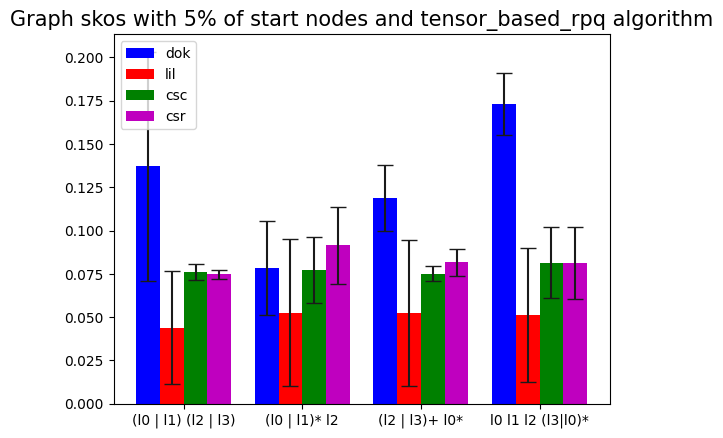

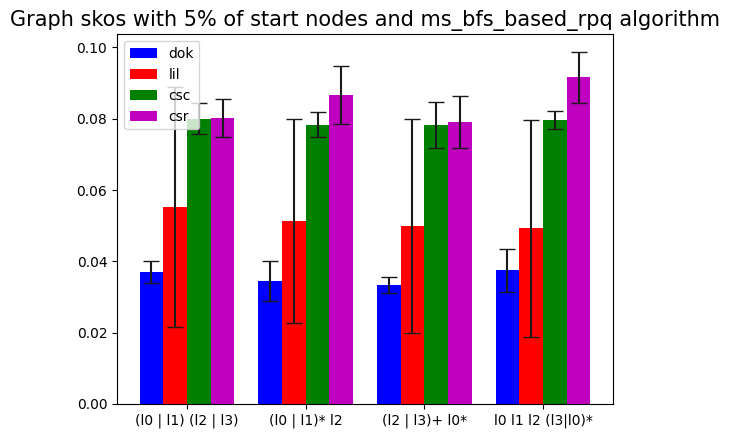

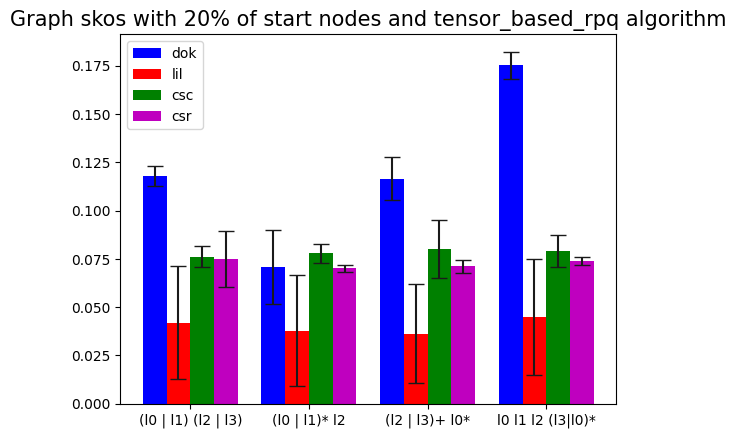

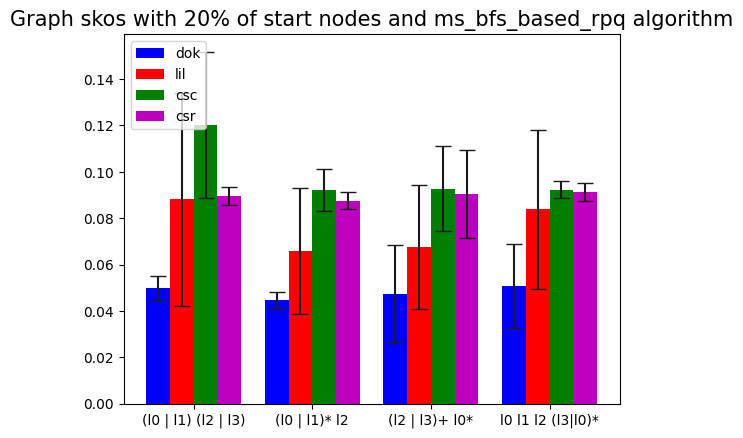

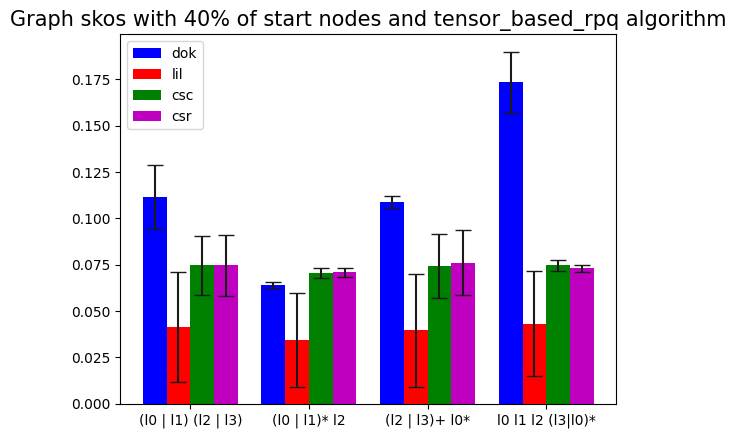

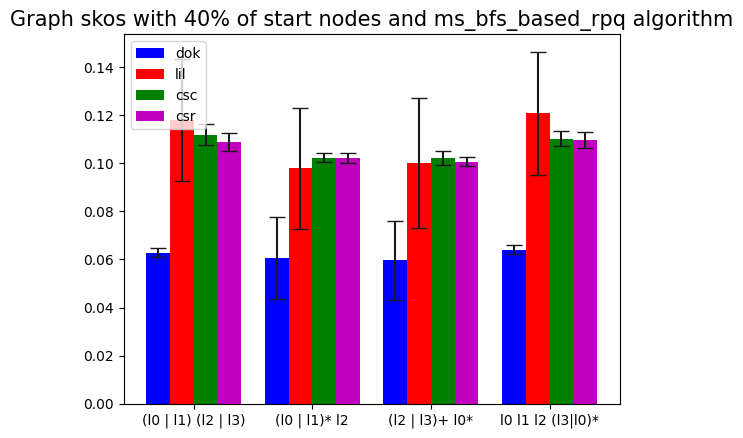

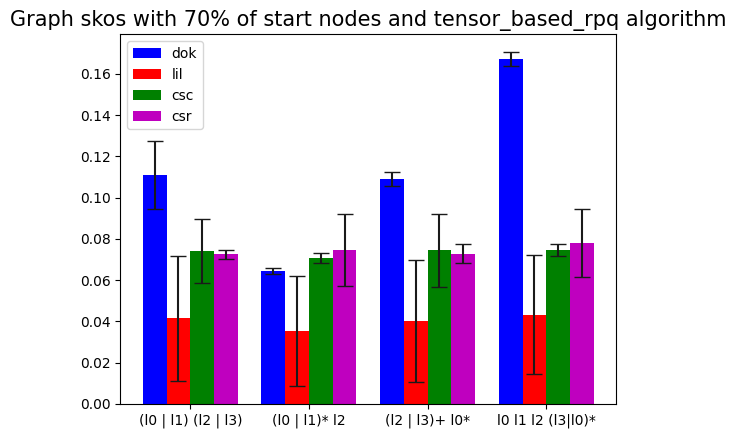

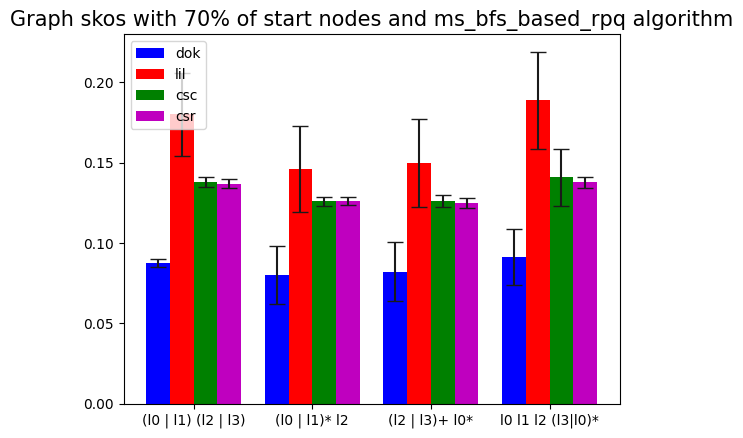

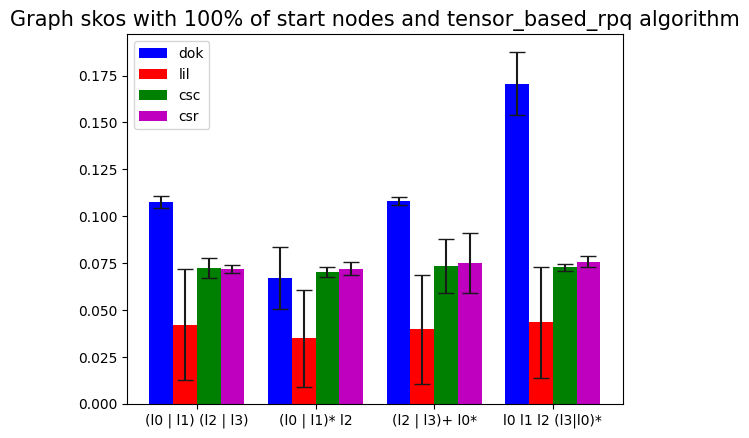

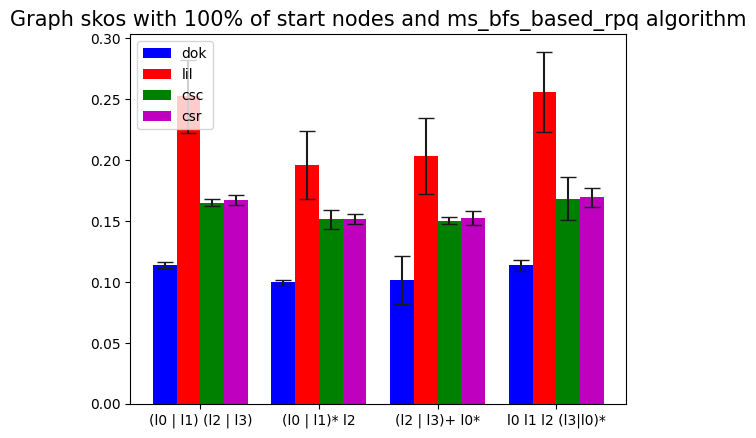

In [111]:
create_bar("skos", pdres1, percents=start_nodes_percent)

Как можно увидеть, на `dok` матрице `tensor_based_rpq` показывает наихудшие результаты, в то время как `ms_bfs_based_rpq` наилучшие. Также оба алгоритма неплохо себя показывают на `lil` матрице, но при увеличении количества стартовых вершин `ms_bfs_based_rpq` начинает работать на `lil` все хуже и хуже. Наибольшую стабильность оба алгоритма показали на `csc` и `csr` матрицах.

## Проведем замеры для `wine`

In [65]:
result2 = test_graph("wine", run_num)

[2024-10-14 16:54:49]>INFO>Found graph with name='wine'
[2024-10-14 16:54:49]>INFO>Load archive graph_archive=WindowsPath('C:/Users/kotyr/PycharmProjects/formal-lang-course/.venv/Lib/site-packages/cfpq_data/data/graphs/wine.tar.gz')
[2024-10-14 16:54:49]>INFO>Unzip graph name='wine' to file graph=WindowsPath('C:/Users/kotyr/PycharmProjects/formal-lang-course/.venv/Lib/site-packages/cfpq_data/data/graphs/wine/wine.csv')
[2024-10-14 16:54:49]>INFO>Remove archive graph_archive=WindowsPath('C:/Users/kotyr/PycharmProjects/formal-lang-course/.venv/Lib/site-packages/cfpq_data/data/graphs/wine.tar.gz')
[2024-10-14 16:54:49]>INFO>Load graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x0000014BE5CC2AE0> from path=WindowsPath('C:/Users/kotyr/PycharmProjects/formal-lang-course/.venv/Lib/site-packages/cfpq_data/data/graphs/wine/wine.csv')
[2024-10-14 16:54:49]>INFO>Found graph with name='wine'
[2024-10-14 16:54:50]>INFO>Load archive graph_archive=WindowsPath('C:/Users/kotyr/PycharmProjec

In [112]:
pdres2 = analyze_execution_times_avg(result2)
pdres2

,Start percent,Matrix Type,Regex,Algorithm,Mean Time (s),Std Dev (s),95% CI Low,95% CI High
0,5,dok,(l0 | l1) (l2 | l3),tensor_based_rpq,2.116700,0.072235,2.089727,2.143673
1,5,dok,(l0 | l1) (l2 | l3),ms_bfs_based_rpq,0.214239,0.042227,0.198471,0.230007
2,5,dok,(l0 | l1)* l2,tensor_based_rpq,1.056200,0.044218,1.039689,1.072711
3,5,dok,(l0 | l1)* l2,ms_bfs_based_rpq,0.209424,0.042444,0.193575,0.225273
4,5,dok,(l2 | l3)+ l0*,tensor_based_rpq,2.131119,0.046813,2.113638,2.148599
...,...,...,...,...,...,...,...,...
155,100,csr,(l0 | l1)* l2,ms_bfs_based_rpq,0.930666,0.052033,0.911236,0.950095
156,100,csr,(l2 | l3)+ l0*,tensor_based_rpq,0.531874,0.041830,0.516254,0.547494
157,100,csr,(l2 | l3)+ l0*,ms_bfs_based_rpq,0.928837,0.049741,0.910263,0.947410
158,100,csr,l0 l1 l2 (l3|l0)*,tensor_based_rpq,0.531430,0.039442,0.516702,0.546157


### Сравним результаты для `wine` на различного количества стартовых нод
В графики не была включена `dok` матрица для `tensor_based_rpq`, потому что она показывает значительно худшие результаты. 

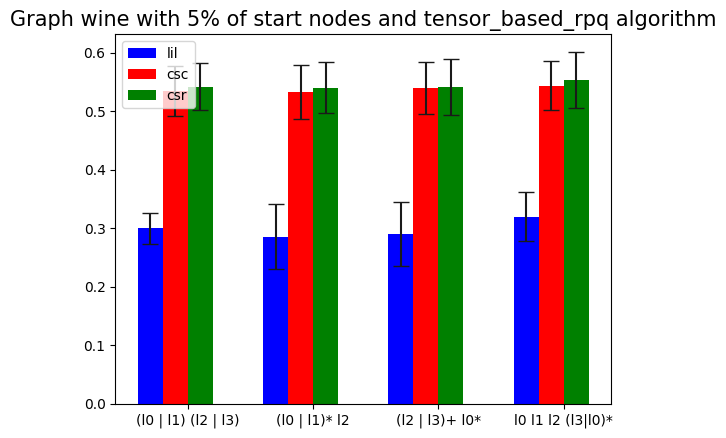

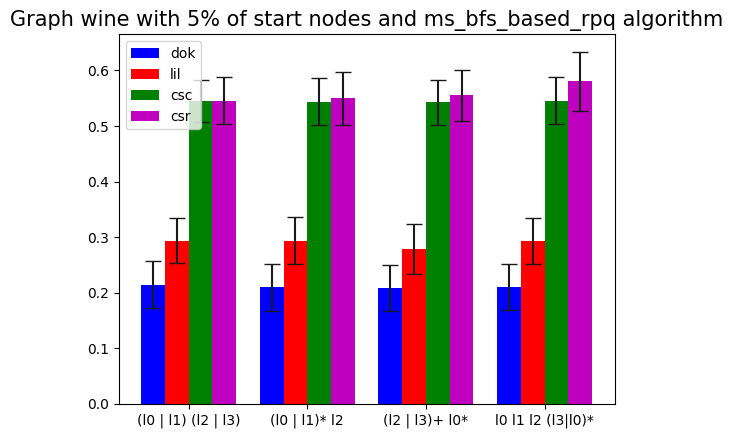

In [118]:
create_bar(
    "wine",
    pdres2,
    percents=[5],
    algos=["tensor_based_rpq"],
    matrices=["lil", "csc", "csr"],
)
create_bar("wine", pdres2, percents=[5], algos=["ms_bfs_based_rpq"])

При количестве стартовых вершин 5% от размера графа, `ms_bfs_based_rpq` показывает производительность в примерно 1.5 раза лучше. Увеличим количество стартовых нод, оставив только `lil` и `dok` матрицы соответственно, как самые быстрые.

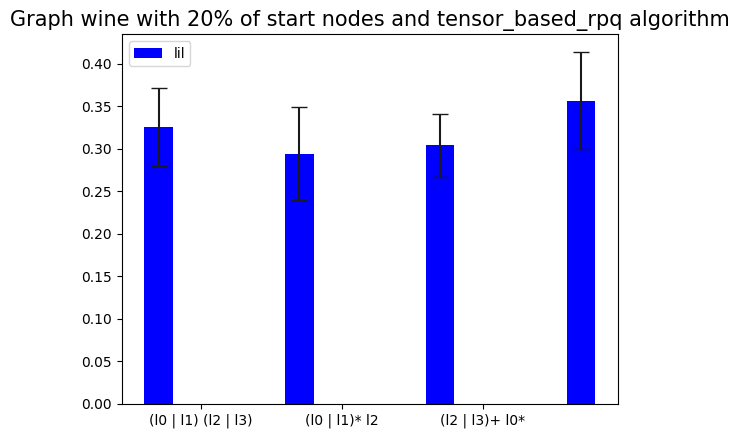

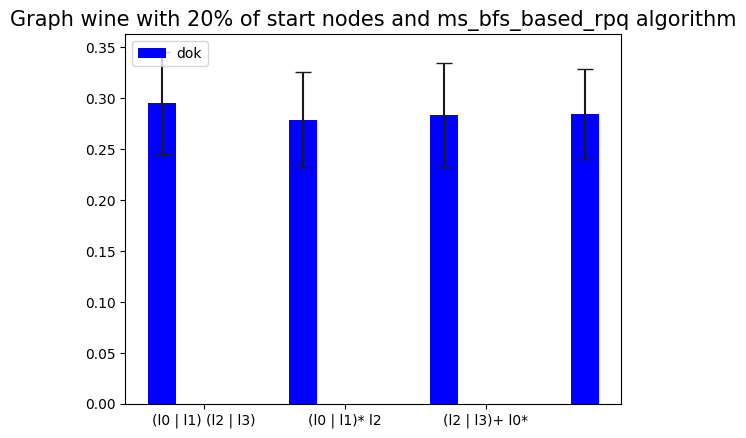

In [120]:
create_bar(
    "wine",
    pdres2,
    percents=start_nodes_percent[1:2],
    algos=["tensor_based_rpq"],
    matrices=["lil"],
)
create_bar(
    "wine",
    pdres2,
    percents=start_nodes_percent[1:2],
    algos=["ms_bfs_based_rpq"],
    matrices=["dok"],
)

Можно увидеть, что `ms_bfs_based_rpq` все еще показывает результаты получше, но уже с небольшим отрывом.

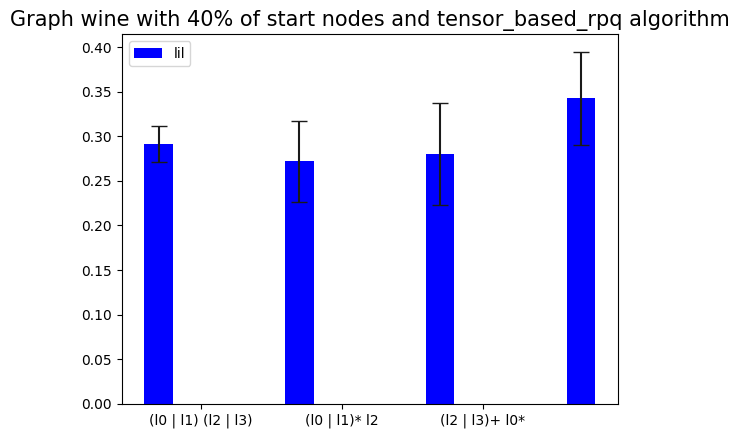

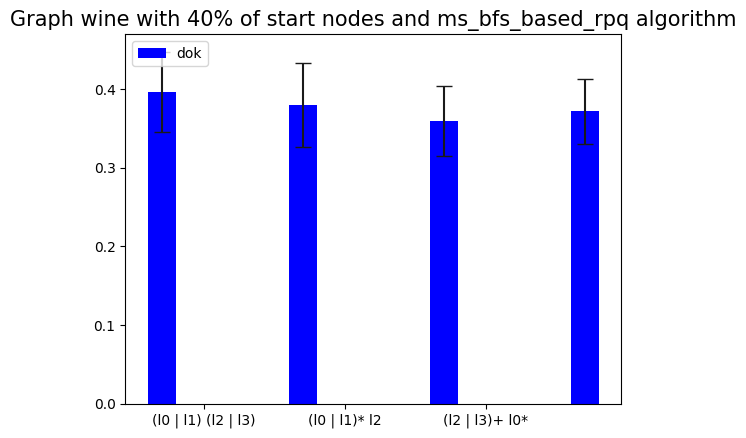

In [121]:
create_bar(
    "wine",
    pdres2,
    percents=start_nodes_percent[2:3],
    algos=["tensor_based_rpq"],
    matrices=["lil"],
)
create_bar(
    "wine",
    pdres2,
    percents=start_nodes_percent[2:3],
    algos=["ms_bfs_based_rpq"],
    matrices=["dok"],
)

Тут уже `tensor_based_rpq` показывает лучшие результаты. Соответственно при выборе множества стартовых вершин в 40% больше - выгоднее решать задачу для всего множества стартовых вершин.

Далее приведены замеры для 70% и 100%.

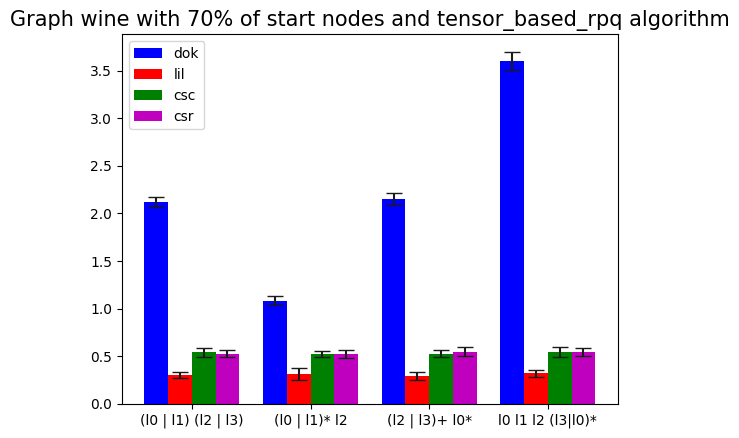

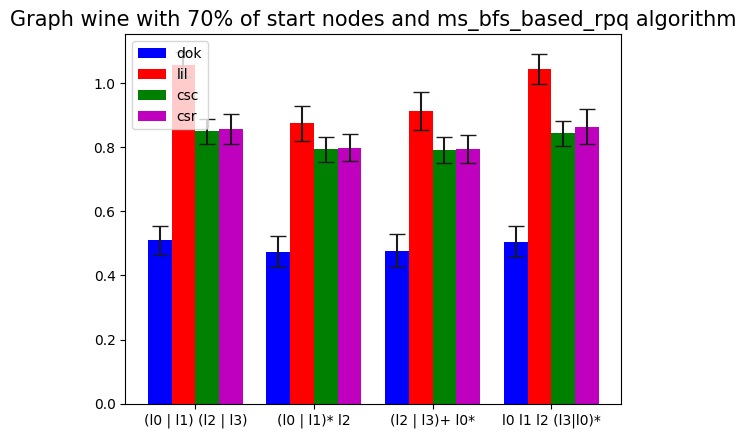

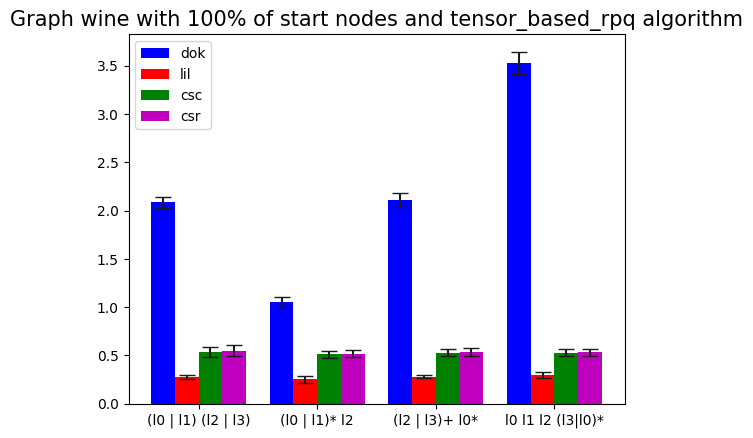

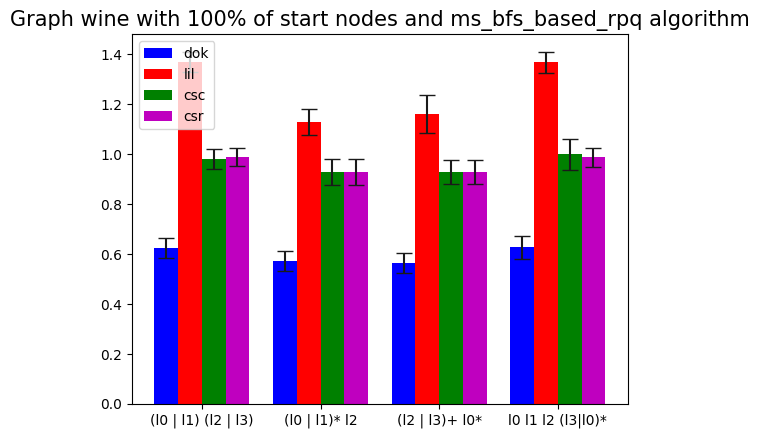

In [122]:
create_bar("wine", pdres2, percents=start_nodes_percent[3:])

Можно увидеть, что `ms_bfs_based_rpq` уже значительно отстает от `tensor_based_rpq` на больших процентах и всем множестве вершин.

## Проведем замеры для `funding`

In [67]:
result3 = test_graph("funding", run_num)

[2024-10-14 17:57:18]>INFO>Found graph with name='funding'
[2024-10-14 17:57:18]>INFO>Load archive graph_archive=WindowsPath('C:/Users/kotyr/PycharmProjects/formal-lang-course/.venv/Lib/site-packages/cfpq_data/data/graphs/funding.tar.gz')
[2024-10-14 17:57:18]>INFO>Unzip graph name='funding' to file graph=WindowsPath('C:/Users/kotyr/PycharmProjects/formal-lang-course/.venv/Lib/site-packages/cfpq_data/data/graphs/funding/funding.csv')
[2024-10-14 17:57:18]>INFO>Remove archive graph_archive=WindowsPath('C:/Users/kotyr/PycharmProjects/formal-lang-course/.venv/Lib/site-packages/cfpq_data/data/graphs/funding.tar.gz')
[2024-10-14 17:57:19]>INFO>Load graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x0000014BE621D520> from path=WindowsPath('C:/Users/kotyr/PycharmProjects/formal-lang-course/.venv/Lib/site-packages/cfpq_data/data/graphs/funding/funding.csv')
[2024-10-14 17:57:19]>INFO>Found graph with name='funding'
[2024-10-14 17:57:19]>INFO>Load archive graph_archive=WindowsPath('C

In [72]:
pdres3 = analyze_execution_times_avg(result3)
pdres3

,Start percent,Matrix Type,Regex,Algorithm,Mean Time (s),Std Dev (s),95% CI Low,95% CI High
0,5,dok,(l0 | l1) (l2 | l3),tensor_based_rpq,2.242440,0.078834,2.213003,2.271878
1,5,dok,(l0 | l1) (l2 | l3),ms_bfs_based_rpq,0.133092,0.028337,0.122511,0.143673
2,5,dok,(l0 | l1)* l2,tensor_based_rpq,1.062655,0.034060,1.049937,1.075373
3,5,dok,(l0 | l1)* l2,ms_bfs_based_rpq,0.128459,0.029837,0.117317,0.139600
4,5,dok,(l2 | l3)+ l0*,tensor_based_rpq,2.226923,0.064905,2.202687,2.251159
...,...,...,...,...,...,...,...,...
155,100,csr,(l0 | l1)* l2,ms_bfs_based_rpq,0.728154,0.030770,0.716664,0.739643
156,100,csr,(l2 | l3)+ l0*,tensor_based_rpq,0.318086,0.033426,0.305604,0.330567
157,100,csr,(l2 | l3)+ l0*,ms_bfs_based_rpq,0.741231,0.039118,0.726624,0.755838
158,100,csr,l0 l1 l2 (l3|l0)*,tensor_based_rpq,0.321280,0.033588,0.308738,0.333821


### Также рассмотрим результаты для `funding` и сравним с `wine`

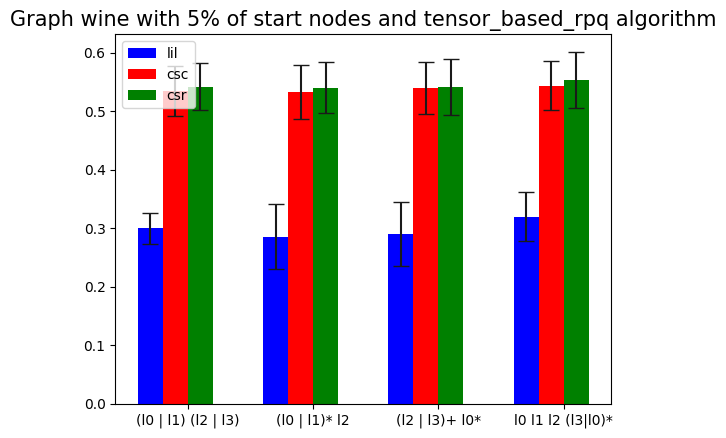

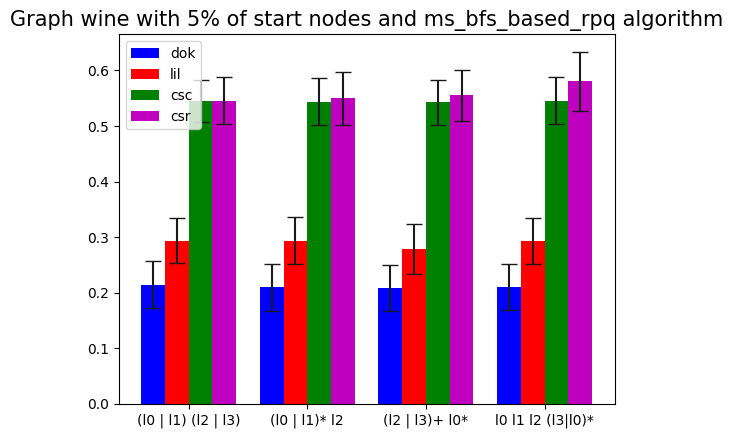

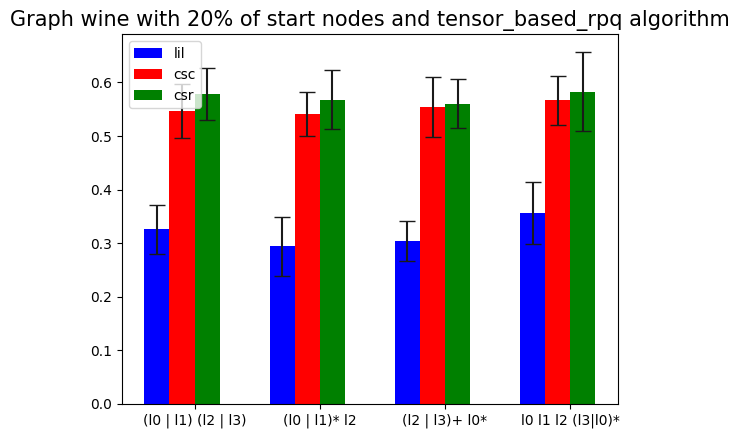

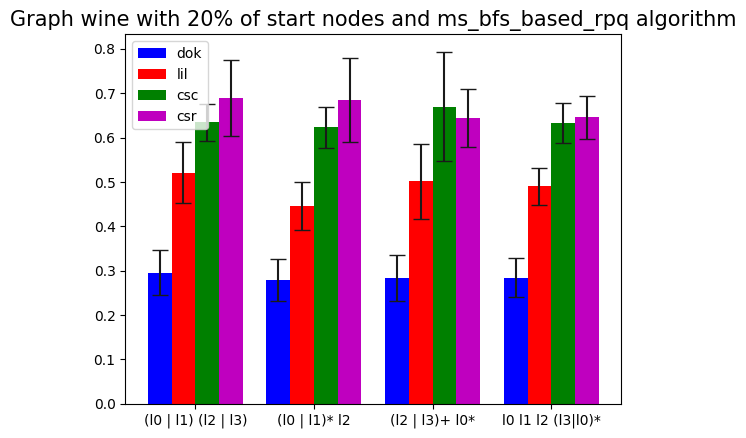

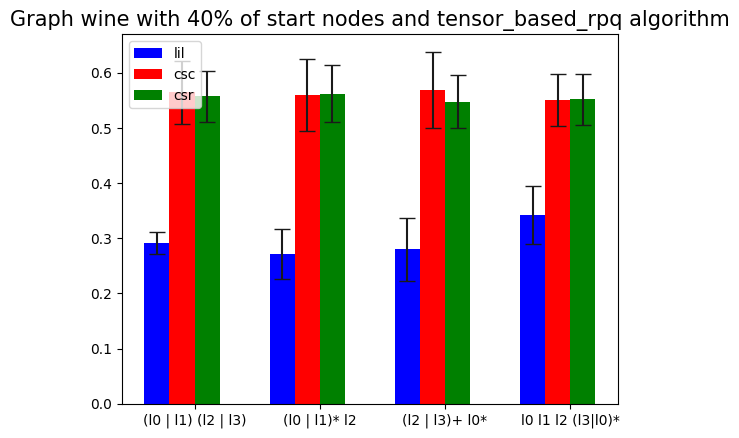

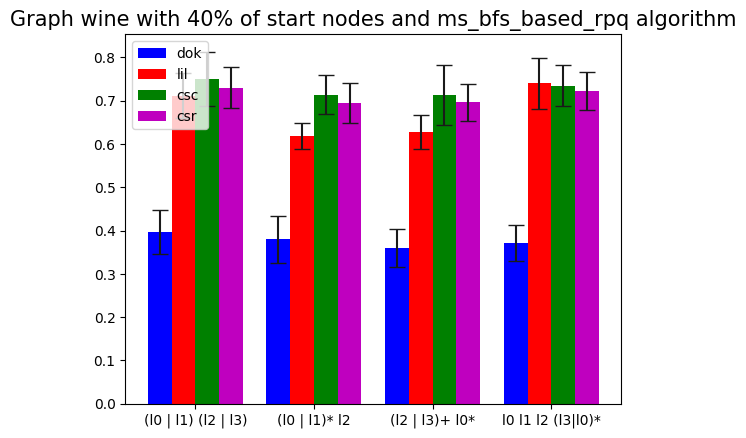

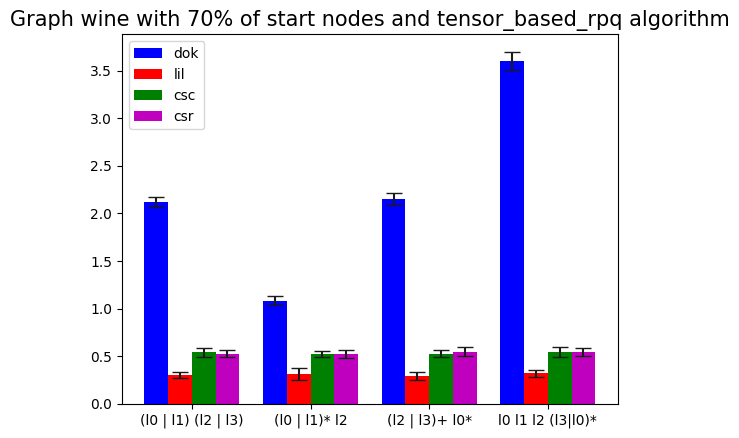

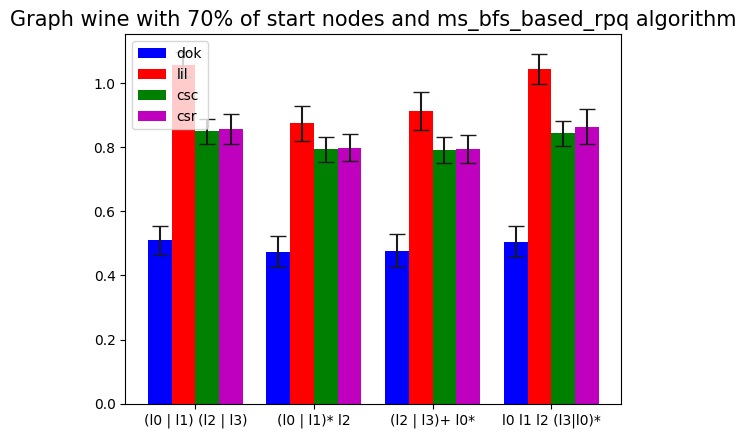

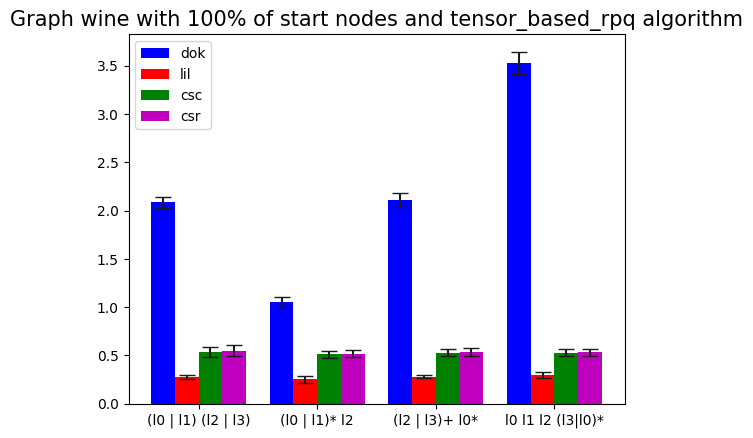

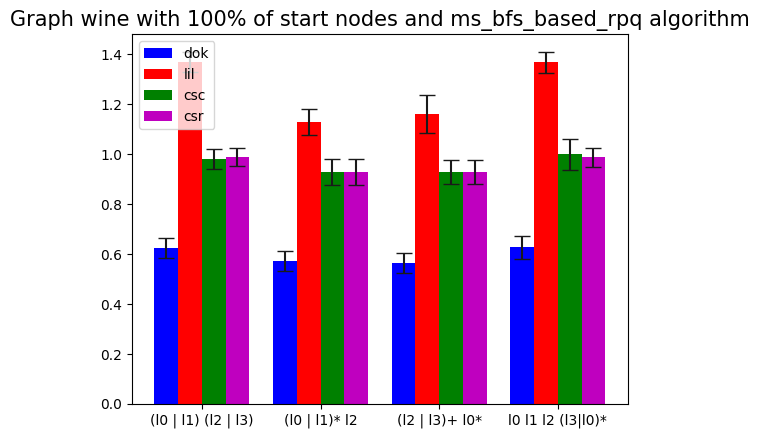

In [126]:
create_bar(
    "wine",
    pdres2,
    percents=[5],
    algos=["tensor_based_rpq"],
    matrices=["lil", "csc", "csr"],
)
create_bar("wine", pdres2, percents=[5], algos=["ms_bfs_based_rpq"])
create_bar(
    "wine",
    pdres2,
    percents=[20],
    algos=["tensor_based_rpq"],
    matrices=["lil", "csc", "csr"],
)
create_bar("wine", pdres2, percents=[20], algos=["ms_bfs_based_rpq"])
create_bar(
    "wine",
    pdres2,
    percents=[40],
    algos=["tensor_based_rpq"],
    matrices=["lil", "csc", "csr"],
)
create_bar("wine", pdres2, percents=[40], algos=["ms_bfs_based_rpq"])
create_bar("wine", pdres2, percents=start_nodes_percent[3:])

Получаем аналогичные для `wine` результаты - при количестве стартовых вершин больше 40% выгоднее решать задачу для всех стартовых вершин и выбирать нужные.

## Результаты
1. Для `tensor_base_rpq` алгоритма лучше всего подходит `lil` матрица, хуже всего `dok`.
2. Для `ms_bfs_based_rpq` алгоритма лучше всего подходит `dok` матрица, `lil` матрица тоже неплохо себя показывает, но только на небольшом размере стартового множества.
3. При размере стартового множества вершин больше 40% выгоднее решать задачу для всего множества вершин и из них выбирать нужные (`tensor_based_rpq` алгоритм). Для множества меньше 20% выгоднее оказывается `ms_bfs_based_rpq` алгоритм.